In [53]:
# 1MBA (myoglobin)
#seq = "SLSAAEADLAGKSWAPVFANKNANGLDFLVALFEKFPDSANFFADFKGKSVADIKASPKLRDVSSRIFTRLNEFVNNAANAGKMSAMLSQFAKEHVGFGVGSAQFENVRSMFPGFVASVAAPPAGADAAWTKLFGLIIDALKAAGA"

# 1MJC
seq = "SGKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLDEGQKVSFTIESGAKGPAAGNVTSL"

with open("ss.a3m", "w") as f:
    f.write(f">test\n{seq}\n")

header = f"test|protein|ss.a3m"

with open("ss.fasta", "w") as f:
    f.write(f">{header}\n{seq}\n")



In [69]:
num_samples = 64
%run /home/gridsan/jroney/solab/af3/FoldScaling/boltz/src/boltz/main.py predict ss.fasta --diffusion_samples {num_samples} --recycling_steps 1 --override --skip_pred

Checking input data.
Found existing predictions, will override.
Running predictions for 1 structure
Processing input data.
Found a manifest file at output directory: boltz_results_ss
All examples in data are processed. Updating the manifest


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Skipping prediction step as requested.


In [70]:
processed = _boltz_inputs
data_module = BoltzInferenceDataModule(
    manifest=processed.manifest,
    target_dir=processed.targets_dir,
    msa_dir=processed.msa_dir,
    num_workers=1,
    constraints_dir=processed.constraints_dir,
)

batch = next(iter(data_module.predict_dataloader()))
batch = {k:v.cuda() if torch.is_tensor(v) else v for k,v in batch.items()}
model = _boltz_module.cuda()

In [71]:
trunk_out = model(
        batch,
        recycling_steps=model.predict_args["recycling_steps"],
        num_sampling_steps=model.predict_args["sampling_steps"],
        diffusion_samples=num_samples,
        return_final_reps=True,
        skip_diffusion=True)

In [72]:
diff_outputs = model.structure_module.sample(
                    s_trunk=trunk_out['s_trunk'],
                    z_trunk=trunk_out['z_trunk'],
                    s_inputs=trunk_out['s_inputs'],
                    feats=trunk_out['feats'],
                    relative_position_encoding=trunk_out['relative_position_encoding'],
                    num_sampling_steps=model.predict_args["sampling_steps"],
                    atom_mask=trunk_out['feats']["atom_pad_mask"],
                    multiplicity=num_samples,
                    train_accumulate_token_repr=model.training,
                    steering_args={'fk_steering' : False, 'guidance_update': False},
                    custom_noise=None,
                    custom_potentials=[]
                )

In [73]:
model.confidence_module.use_s_diffusion=False
conf_out = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([ 5.,  5.,  0.,  3.,  4.,  7., 14., 13., 10.,  3.]),
 array([0.39900368, 0.41007233, 0.42114094, 0.43220958, 0.44327819,
        0.45434684, 0.46541548, 0.47648409, 0.48755273, 0.49862134,
        0.50968999]),
 <BarContainer object of 10 artists>)

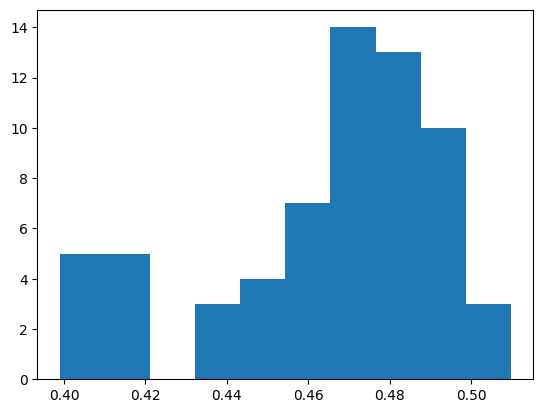

In [74]:
import matplotlib.pyplot as plt

conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() /5
plt.hist(conf_score)

In [75]:
from boltz.model.potentials.potentials import Potential

"""
Class for FK guidance with confidence module as guiding potential
"""

model.steering_args['num_particles']=8
model.steering_args['fk_lambda']=50
model.steering_args['fk_resampling_interval']=5
model.steering_args['guidance_update']=False
model.steering_args['max_fk_noise'] = 100
model.steering_args['potential_type'] = "vanilla"
model.steering_args['noise_coord_potential'] = False

class BoltzConfidencePotential(Potential):

    def compute_args(self, feats, params):
        return None, (), None # dummy return vals
    
    def compute_variable(self, coords, index, compute_gradient=False):

            
        conf_out = model.confidence_module(
                s_inputs=trunk_out['s_trunk'],
                s=trunk_out['s_trunk'],
                z=trunk_out['z_trunk'],
                s_diffusion=None,
                x_pred=coords,
                feats=trunk_out['feats'],
                pred_distogram_logits=trunk_out["pdistogram"],
                multiplicity=model.predict_args["diffusion_samples"] * model.steering_args['num_particles'],
                run_sequentially=False
            )

        conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']) / 5
        conf_score = conf_score.unsqueeze(-1) # this is important because it expects the energy to have many contributions from different indices

        print(conf_score)
        if not compute_gradient:
            return conf_score

        return conf_score, torch.zeros_like(coords) # we can't get a gradient because the prediction is turned into a binned dgram
        
    # def compute_function(self, value, compute_derivative=False):
    #     nrg = -torch.log(value)
    #     if not compute_derivative:
    #         return nrg
        
    #     return nrg, -1/nrg

    def compute_function(self, value, compute_derivative=False):
        nrg = 1-value
        if not compute_derivative:
            return nrg
        
        return nrg, -value

        
        

In [76]:
pot = BoltzConfidencePotential(parameters={
                'guidance_interval': 5,
                'guidance_weight': 0.00,
                'resampling_weight': 1.0,
            })

In [77]:
model.steering_args

{'fk_steering': True,
 'num_particles': 8,
 'fk_lambda': 50,
 'fk_resampling_interval': 5,
 'guidance_update': False,
 'num_gd_steps': 16,
 'max_fk_noise': 100,
 'potential_type': 'vanilla',
 'noise_coord_potential': False}

In [78]:
diff_outputs_guided = model.structure_module.sample(
                        s_trunk=trunk_out['s_trunk'],
                        z_trunk=trunk_out['z_trunk'],
                        s_inputs=trunk_out['s_inputs'],
                        feats=trunk_out['feats'],
                        relative_position_encoding=trunk_out['relative_position_encoding'],
                        num_sampling_steps=model.predict_args["sampling_steps"],
                        atom_mask=trunk_out['feats']["atom_pad_mask"],
                        multiplicity=num_samples,
                        train_accumulate_token_repr=model.training,
                        steering_args=model.steering_args,
                        custom_noise=None,
                        custom_potentials=[pot]
                    )

85.69275665283203
tensor([[0.4794],
        [0.4827],
        [0.4880],
        [0.4824],
        [0.4939],
        [0.4879],
        [0.4863],
        [0.4888],
        [0.4914],
        [0.4823],
        [0.4807],
        [0.4895],
        [0.4846],
        [0.4858],
        [0.4885],
        [0.4887],
        [0.4975],
        [0.4869],
        [0.4870],
        [0.4909],
        [0.4910],
        [0.4849],
        [0.4776],
        [0.4890],
        [0.4956],
        [0.4836],
        [0.4917],
        [0.4835],
        [0.4881],
        [0.4857],
        [0.4940],
        [0.4815],
        [0.4958],
        [0.4932],
        [0.4949],
        [0.4934],
        [0.4916],
        [0.4826],
        [0.4921],
        [0.4883],
        [0.4922],
        [0.4995],
        [0.4902],
        [0.4937],
        [0.4765],
        [0.4785],
        [0.4832],
        [0.4741],
        [0.4847],
        [0.4880],
        [0.4919],
        [0.4832],
        [0.4842],
        [0.4859],
        [0

In [79]:
conf_out_guided = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs_guided['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([ 3.,  4.,  8.,  8., 11.,  8.,  5.,  5.,  5.,  7.]),
 array([0.47843543, 0.48314971, 0.48786399, 0.49257827, 0.49729255,
        0.50200683, 0.50672108, 0.51143539, 0.51614964, 0.52086395,
        0.5255782 ]),
 <BarContainer object of 10 artists>)

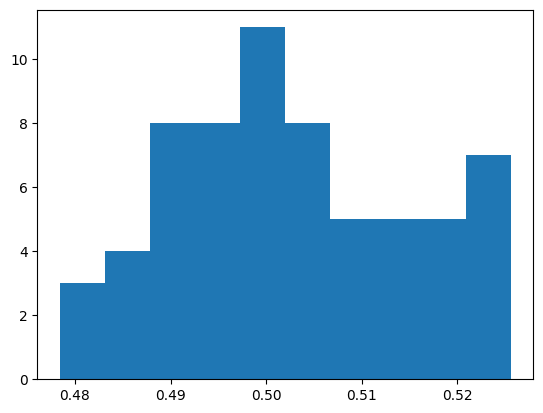

In [80]:
conf_score = (4*conf_out_guided['complex_plddt'] + conf_out_guided['ptm']).cpu().numpy() /5
plt.hist(conf_score)

(array([ 5.,  5.,  0.,  3.,  4.,  7., 14., 13., 10.,  3.]),
 array([0.39900368, 0.41007233, 0.42114094, 0.43220958, 0.44327819,
        0.45434684, 0.46541548, 0.47648409, 0.48755273, 0.49862134,
        0.50968999]),
 <BarContainer object of 10 artists>)

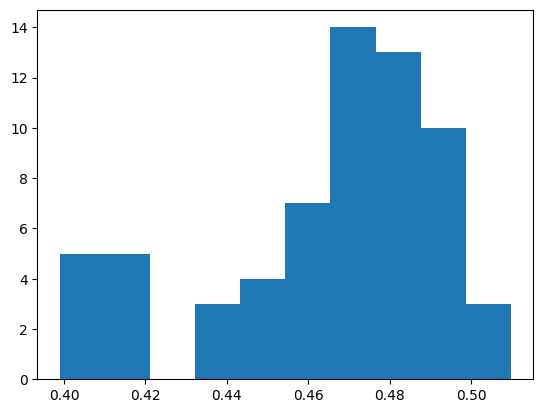

In [81]:
conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() / 5
plt.hist(conf_score)

In [38]:
conf_out['complex_plddt']

tensor([0.5160, 0.5330, 0.5298, 0.5207, 0.5485, 0.5162, 0.5482, 0.5465, 0.5305,
        0.5241, 0.5573, 0.5581, 0.5473, 0.5299, 0.5357, 0.5547, 0.5659, 0.5313,
        0.5481, 0.5367, 0.5211, 0.5407, 0.5385, 0.5246], device='cuda:0')

In [39]:
conf_out_guided['complex_plddt']

tensor([0.5681, 0.5500, 0.5515, 0.5526, 0.5449, 0.5480, 0.5875, 0.5630, 0.5396,
        0.5491, 0.5921, 0.5588, 0.5607, 0.5436, 0.5884, 0.5489, 0.5626, 0.5609,
        0.5434, 0.5401, 0.5579, 0.5681, 0.5425, 0.5508], device='cuda:0')

In [26]:
model.structure_module.num_sampling_steps

5